# Project 3: Subreddit Classification
---

Problem Statement
---

The "TheOnion" subreddit is a subreddit where users can post news articles found on https://www.theonion.com, which is a satirical news site. It is fairly well known that The Onion articles are all satirical in nature, so the news titles usually sound ridiculous. The "nottheonion" subreddit is a subreddit where users can post news articles of true stories that are so mind-blowingly ridiculous that you could have sworn they were from The Onion.

When performing maintenance, an engineer accidentally deleted multiple posts from r/nottheonion and r/theonion. Unfortunately, the engineer was only able to recover the titles of the lost posts. We were therefore tasked to build a classification model which would train on posts submitted before 2022 to classify the recovered posts back to their respective subreddits, r/nottheonion and r/theonion, based solely on the post titles.

Reddit has been thinking of developing machine learning models for automoderators, therefore, we will also be making use of this opportunity to do a proof of concept that machine learning (ML) models could be used to develop automoderators. Moderators are currently spending a substantial amount of their time reviewing user reports and deleting irrelevant posts from the subreddit. In theory, if automoderators developed through ML were deployed, it would be able to classify whether a posts belongs in the subreddit it is in or not. Having automoderators police the subreddit for irrelevant posts would free up time for human moderators, who are volunteers, to do things that they want to do.

We will explore using four models (Random Forest Classifier, Logistic Regression, Multinomial Naive Bayes and Support Vector Classifier) and select the model that is the most successful in classifying the subreddit posts. Success will be evaluated through the accuracy score and F1 score, as we want both false positives and false negatives to be minimised.

Executive Summary
---

Data was collected from two subreddits, r/TheOnion and r/nottheonion, using the PushShift API. A total of 4000 posts were collected, 2000 from each subreddit. As it is possible that the same post could be posted multiple times to farm Reddit karma, we ensured that no duplicate posts or reposts were collected by searching through the list of posts scraped at that point in time. After dropping data fields that seemed irrelevant during the data collection step, the data was loaded into a data frame, and analysis was performed on the titles of the posts using Natural Language Processing techniques. 

The data was found to have no missing values, which is expected since the data comes from Reddit. The average post lengths in terms of both character lengths and word lengths were similar between the two subreddits. The title text was converted into a bag of words using CountVectorizer for further analysis. The most popular unigrams and bigrams for r/TheOnion indicated that satirical article titles are up-to-date with current affairs, as they mention US politics and the global pandemic. As for r/nottheonion, it indicated that the ridiculous news usually involved a person, and more often than not, a "Florida man".

The title text of the posts were preprocessed by removing stopwords from the nltk library, and lemmatized using the WordNetLemmatizer, before it was fed into a pipeline containing TfidfVectorizer and a classification model. A total of 4 classification models were explored: Random Forest, Logistic Regression, Multinomial Naive Bayes and Support Vector Machine. GridSearchCV was used to tune the hyperparameters of the TfidfVectorizer and the classification models. A 75/25 train test split was performed before feeding the data into each pipeline. Each model was evaluated using the accuracy score and F1 score. The confusion matrix and ROC curves were also analysed to see if the findings matched the accuracy and F1 scores. The best performing model was found to be the Support Vector Classifier with an accuracy of 79%. Given that this is the first iteration of a possible ML automoderator, the results are promising and show that ML automoderators are feasible.

Exploratory Data Analysis  
---

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score, plot_roc_curve, ConfusionMatrixDisplay
from sklearn.svm import SVC

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

### Data Dictionary

| Field       | Description                          |
|-------------|--------------------------------------|
| author      | Author of the post                   |
| created_utc | Unix time of post creation           |
| domain      | Domain of the URL linked in the post |
| full_link   | Reddit URL to the post               |
| id          | Unique id of the post                |
| subreddit   | Subreddit of the post                |
| title       | Title of the post                    |
| url         | URL linked in the post               |

### Read data

In [2]:
# import data to DataFrame
subreddit_posts = pd.read_csv("../data/theonion_nottheonion_posts.csv")
subreddit_posts.shape

(4000, 8)

In [3]:
# looking at the first 5 records (from r/TheOnion)
subreddit_posts.head()

,author,created_utc,domain,full_link,id,subreddit,title,url
0,mothershipq,1640973300,theonion.com,https://www.reddit.com/r/TheOnion/comments/rsz...,rszeht,TheOnion,Surgeon Kind Of Pissed Patient Seeing Her Defo...,https://www.theonion.com/surgeon-kind-of-pisse...
1,-ImYourHuckleberry-,1640971771,theartnewspaper.com,https://www.reddit.com/r/TheOnion/comments/rsy...,rsyv0j,TheOnion,McDonald’s blocked from building drive-through...,https://www.theartnewspaper.com/2021/12/31/mcd...
2,dwaxe,1640955671,theonion.com,https://www.reddit.com/r/TheOnion/comments/rst...,rstfnv,TheOnion,Gwyneth Paltrow Touts New Diamond-Encrusted Tr...,https://www.theonion.com/gwyneth-paltrow-touts...
3,dwaxe,1640955669,theonion.com,https://www.reddit.com/r/TheOnion/comments/rst...,rstfn1,TheOnion,Artist Crafting Music Box Hopes It Delights At...,https://www.theonion.com/artist-crafting-music...
4,dwaxe,1640955668,theonion.com,https://www.reddit.com/r/TheOnion/comments/rst...,rstfmf,TheOnion,Homeowner Trying To Smoke Out Snakes Accidenta...,https://www.theonion.com/homeowner-trying-to-s...


In [4]:
# looking at the last 5 records (from r/nottheonion)
subreddit_posts.tail()

,author,created_utc,domain,full_link,id,subreddit,title,url
3995,everything_is_bad,1639452196,dailymail.co.uk,https://www.reddit.com/r/nottheonion/comments/...,rfxx1k,nottheonion,"Michigan school shooter Ethan Crumbley, 15, as...",https://www.dailymail.co.uk/news/article-10305...
3996,traker998,1639452130,dailymail.co.uk,https://www.reddit.com/r/nottheonion/comments/...,rfxwar,nottheonion,Scientists studying microplastics in Antarctic...,https://www.dailymail.co.uk/sciencetech/articl...
3997,traker998,1639452005,telegraph.co.uk,https://www.reddit.com/r/nottheonion/comments/...,rfxuwu,nottheonion,Scientists studying microplastics in Antarctic...,https://www.telegraph.co.uk/news/2021/12/13/sc...
3998,caneel_bay,1639450817,jalopnik.com,https://www.reddit.com/r/nottheonion/comments/...,rfxgxq,nottheonion,NY Congressional Candidate Claims To Use An Ab...,https://jalopnik.com/new-york-congressional-ca...
3999,MatiasPalacios,1639449909,abc3340.com,https://www.reddit.com/r/nottheonion/comments/...,rfx6fh,nottheonion,Nearly 70-year-old murals taken down at Univer...,https://abc3340.com/news/nation-world/nearly-7...


In [5]:
subreddit_posts.isna().sum()

author         0
created_utc    0
domain         0
full_link      0
id             0
subreddit      0
title          0
url            0
dtype: int64

No missing values found.

In [6]:
# checking for duplicate posts within r/TheOnion
subreddit_posts[subreddit_posts['subreddit']=="TheOnion"]['id'].nunique()

2000

In [7]:
# checking for posts with duplicate titles within r/TheOnion
subreddit_posts[subreddit_posts['subreddit']=="TheOnion"]['title'].nunique()

2000

In [8]:
# checking for posts with duplicate urls within r/TheOnion
subreddit_posts[subreddit_posts['subreddit']=="TheOnion"]['url'].nunique()

2000

No duplicate posts (based on 'id') or posts with duplicate content (containing same title or same url) were found in the posts scraped from r/TheOnion. Duplicate posts or posts with duplicate content were already accounted for in the scraping.

In [9]:
# checking for duplicate posts within r/nottheonion
subreddit_posts[subreddit_posts['subreddit']=="nottheonion"]['id'].nunique()

2000

In [10]:
# checking for posts with duplicate titles within r/nottheonion
subreddit_posts[subreddit_posts['subreddit']=="nottheonion"]['title'].nunique()

2000

In [11]:
# checking for posts with duplicate urls within r/nottheonion
subreddit_posts[subreddit_posts['subreddit']=="nottheonion"]['url'].nunique()

2000

No duplicate posts (based on 'id') or posts with duplicate content (containing same title or same url) were found in the posts scraped from r/nothteonion. Duplicate posts or posts with duplicate content were already accounted for in the scraping.

In [12]:
# top 10 most referenced domain in r/TheOnion
subreddit_posts[subreddit_posts['subreddit']=="TheOnion"]['domain'].value_counts().head(10)

theonion.com                  1172
politics.theonion.com          142
local.theonion.com             115
youtube.com                     83
youtu.be                        79
ogn.theonion.com                73
i.redd.it                       71
entertainment.theonion.com      70
sports.theonion.com             52
reddit.com                      11
Name: domain, dtype: int64

Majority of posts are from theonion.com, which is unsurprising since r/TheOnion only allows posts from The Onion

In [13]:
# top 10 most referenced domain in r/nottheonion
subreddit_posts[subreddit_posts['subreddit']=="nottheonion"]['domain'].value_counts().head(10)

starlightinternational786.world    76
virlan.co                          69
theguardian.com                    60
youtu.be                           43
bbc.com                            36
cnn.com                            35
nypost.com                         33
foxnews.com                        32
apnews.com                         30
dailymail.co.uk                    29
Name: domain, dtype: int64

Of the top 10 referenced domains in r/nottheonion, 8 are news websites, which is unsurprising. What is surprising are the top 2 domains, starlightinternational786 and virlan. starlightinternational786 is a blog that posts on multiple topics, and virlan is a website that posts trending and viral news. They could be hosting trending or viral news on their website in order to generate traffic.

In [14]:
# top 10 posters in r/TheOnion
subreddit_posts[subreddit_posts['subreddit']=="TheOnion"]['author'].value_counts().head(10)

dwaxe             308
aresef            276
Sanlear           128
ThatsMyPhoenix     90
coolwali           68
TheGuvnor247       67
mothershipq        63
El_Zarco           44
Exastiken          38
[deleted]          25
Name: author, dtype: int64

There are many frequent posters in r/TheOnion. This could be because posts in r/TheOnion are mostly satirical posts from theonion.com so people can easily post it in the subreddit.

In [15]:
# top 10 posters in r/nottheonion
subreddit_posts[subreddit_posts['subreddit']=="nottheonion"]['author'].value_counts().head(10)

Starlight-786           102
virlan4trendnews         70
-Omegamart-              31
Darth_Kahuna             31
[deleted]                26
XGN_Freshly              26
SelectiveSanity          20
geekman20                15
RealityCrave             10
Naive-Helicopter-700      9
Name: author, dtype: int64

The top 2 authors are Starlight-786 and virlan4trendnews. This coincides with the most referenced domain, and they could be posting trending or viral news to r/nottheonion to generate traffic to their respective websites. 

There is a '\[deleted\]' author in both r/TheOnion and r/nottheonion. This means the reddit account was deleted, and does not mean that there is an author with the name '\[deleted\]'. Since all deleted accounts will be labeled as such, it is unlikely that it had belonged to the same author.

#### Post character count

In [16]:
# generating new column in DataFrame containing character count
subreddit_posts['char_count'] = subreddit_posts['title'].apply(len)

In [17]:
# getting average character count per subreddit
subreddit_posts.groupby('subreddit')['char_count'].mean()

subreddit
TheOnion       76.0745
nottheonion    74.0120
Name: char_count, dtype: float64

The average number of characters in a post are similar for both subreddits which is unsurprising as the post titles tend to be news article titles.

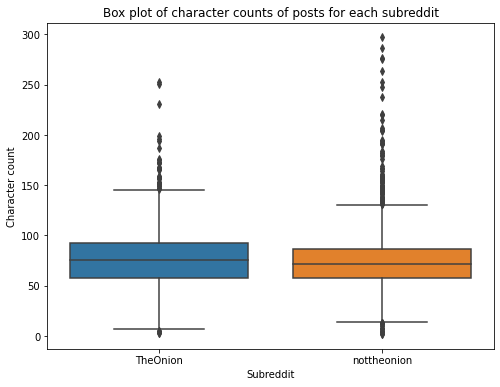

In [18]:
# boxplot of character count for each subreddit
plt.figure(figsize=(8,6))
sns.boxplot(x=subreddit_posts['subreddit'],y=subreddit_posts['char_count'])
plt.xlabel("Subreddit")
plt.ylabel("Character count")
plt.title("Box plot of character counts of posts for each subreddit");

In [19]:
# summary statistics of character count
subreddit_posts.groupby("subreddit")["char_count"].describe()

,count,mean,std,min,25%,50%,75%,max
subreddit,,,,,,,,
TheOnion,2000.0,76.0745,28.557481,3.0,58.00,76.0,93.0,253.0
nottheonion,2000.0,74.0120,31.501016,2.0,57.75,72.0,87.0,297.0


From the boxplot, the number of characters in both subreddits is quite variable. The boxplot identified some outliers so we will take a look at some of them. More than 75% of the posts have less than 100 characters.

In [20]:
# top 10 posts from r/TheOnion with more than 150 characters
subreddit_posts[(subreddit_posts["subreddit"]=="TheOnion") & (subreddit_posts["char_count"]>150)]["title"].head(10)

27      Hey Gamers, We Know We Can Sometimes Be A Litt...
116     The Sydney Opera House in Australia has renewe...
464     Most traders are in a situation where they are...
627     Oklahoma house approves first of a kind water ...
711     ‘Fortnite’ Mobile Fans Will Hate This: Apple S...
813     Epic Clapback: Wendy’s Posted A Sassy Tweet Ab...
954     8 People Having A Way Better Day Than You, Alt...
956     Tough: The New TMNT Game Follows A European Tr...
1052    U.S. diplomats forced by China to undergo anal...
1062    Thomas Bangalter of Daft Punk passed away peac...
Name: title, dtype: object

In [21]:
# top 10 posts from r/nottheonion with more than 150 characters
subreddit_posts[(subreddit_posts["subreddit"]=="nottheonion") & (subreddit_posts["char_count"]>150)]["title"].head(10)

2041    Upset over their grievances not being addresse...
2069    Marjorie Taylor Greene Says She Wants To Take ...
2120    Capital Hospital Islamabad Jobs 2022 for Medic...
2147    Turkey’s Treasury and Finance Minister Nureddi...
2161    TIL: In 2006, a woman farted on a plane and tr...
2235    Elton John stiffed the Pinball Hall of Fame af...
2245    [Campbell] Due to a stadium ban, Sparta Prague...
2365    Anti-vaxxer, who had bragged that he walked in...
2421    @RandPaul: How to steal an election: “Seeding ...
2422    Man who used his freedom of speech in "Let's g...
Name: title, dtype: object

The posts that were longer than 150 characters look like news article titles. As we are analysing post titles which are news article titles, some article titles could be longer than normal but they are not common

#### Post word count

In [22]:
# creating column to contain split title text
subreddit_posts['words'] = subreddit_posts['title'].str.split()
# creating column to contain word count
subreddit_posts['word_count'] = subreddit_posts['words'].apply(len)

In [23]:
# getting average word count per subreddit
subreddit_posts.groupby('subreddit')['word_count'].mean()

subreddit
TheOnion       12.2175
nottheonion    12.0925
Name: word_count, dtype: float64

The average number of words in a post are similar for both subreddits which is also unsurprising as the post titles tend to be news article titles.

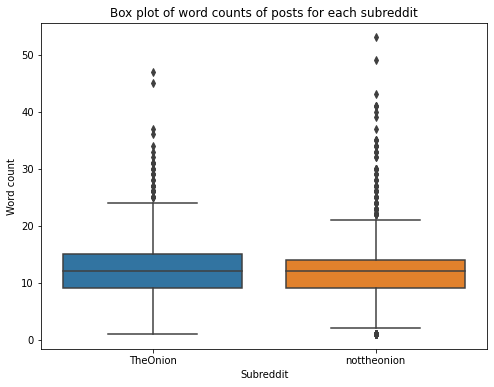

In [24]:
# boxplot of word count for each subreddit
plt.figure(figsize=(8,6))
sns.boxplot(x=subreddit_posts['subreddit'],y=subreddit_posts['word_count'])
plt.xlabel("Subreddit")
plt.ylabel("Word count")
plt.title("Box plot of word counts of posts for each subreddit");

In [25]:
# summary statistics of word count
subreddit_posts.groupby("subreddit")["word_count"].describe()

,count,mean,std,min,25%,50%,75%,max
subreddit,,,,,,,,
TheOnion,2000.0,12.2175,4.878226,1.0,9.0,12.0,15.0,47.0
nottheonion,2000.0,12.0925,5.397361,1.0,9.0,12.0,14.0,53.0


From the boxplot, the number of words in both subreddits is quite variable. The boxplot identified some outliers so we will take a look at some of them. 75% of the posts have less than 15 words.

In [26]:
# top 10 posts from r/TheOnion with more than 30 words
subreddit_posts[(subreddit_posts["subreddit"]=="TheOnion") & (subreddit_posts["word_count"]>30)]["title"].head(10)

27      Hey Gamers, We Know We Can Sometimes Be A Litt...
116     The Sydney Opera House in Australia has renewe...
464     Most traders are in a situation where they are...
711     ‘Fortnite’ Mobile Fans Will Hate This: Apple S...
1052    U.S. diplomats forced by China to undergo anal...
1062    Thomas Bangalter of Daft Punk passed away peac...
1281    Thank you so much for this masterpiece. The le...
1562    Gamers, Are You Not Seeing All The Olives We L...
1575    Everything Is RUINED: Deborah Just Scheduled H...
1620    Major Letdown: It Looks Like The Witch Who Hex...
Name: title, dtype: object

In [27]:
# top 10 posts from r/nottheonion with more than 30 words
subreddit_posts[(subreddit_posts["subreddit"]=="nottheonion") & (subreddit_posts["word_count"]>30)]["title"].head(10)

2041    Upset over their grievances not being addresse...
2069    Marjorie Taylor Greene Says She Wants To Take ...
2161    TIL: In 2006, a woman farted on a plane and tr...
2235    Elton John stiffed the Pinball Hall of Fame af...
2245    [Campbell] Due to a stadium ban, Sparta Prague...
2421    @RandPaul: How to steal an election: “Seeding ...
2714    TIL that in 2009 when giving a TED talk on mal...
2774    Since 1995, the slice held by billionaires has...
2886    Dating Dating Dating, create an account on thi...
3282    These are your leaders and celebrities! This h...
Name: title, dtype: object

The posts that were longer than 30 words look like news article titles.  As we are analysing post titles which are news article titles, some article titles could be longer than normal but they are not common.

#### Most frequent unigrams and bigrams from r/TheOnion

In [28]:
# using CountVectorizer to generate unigrams for analysis
cvec_onion = CountVectorizer(stop_words='english', min_df=3)
cvec_onion.fit(subreddit_posts[subreddit_posts['subreddit']=="TheOnion"]['title'])

onion_cv = cvec_onion.transform(subreddit_posts[subreddit_posts['subreddit']=="TheOnion"]['title'])
onion_df = pd.DataFrame(onion_cv.todense(),columns=cvec_onion.get_feature_names())

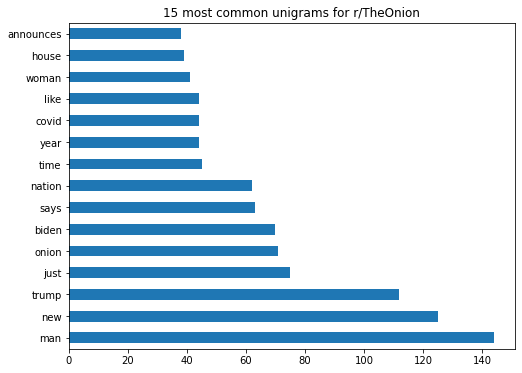

In [29]:
# plotting bargraph for 15 most common unigrams
plt.figure(figsize=(8,6))
onion_df.sum().sort_values(ascending=False).head(15).plot(kind='barh')
plt.title("15 most common unigrams for r/TheOnion");

In [30]:
# printing counts of 15 most common unigrams
onion_df.sum().sort_values(ascending=False).head(15)

man          144
new          125
trump        112
just          75
onion         71
biden         70
says          63
nation        62
time          45
year          44
covid         44
like          44
woman         41
house         39
announces     38
dtype: int64

Quite a number of posts from r/TheOnion seem to mention covid, trump and biden. This makes sense as news pieces from The Onion would have to be up-to-date with current affairs to be relevant and intrigue users.

In [31]:
# using CountVectorizer to generate bigrams for analysis
cvec_onion_bigram = CountVectorizer(ngram_range=(2,2),stop_words='english', min_df=3)
cvec_onion_bigram.fit(subreddit_posts[subreddit_posts['subreddit']=="TheOnion"]['title'])

onion_cv_bigram = cvec_onion_bigram.transform(subreddit_posts[subreddit_posts['subreddit']=="TheOnion"]['title'])
onion_df_bigram = pd.DataFrame(onion_cv_bigram.todense(),columns=cvec_onion_bigram.get_feature_names())

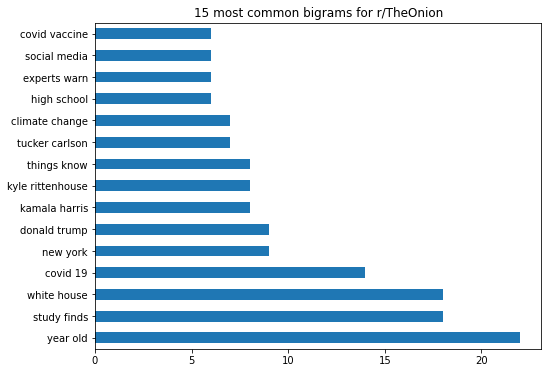

In [32]:
# plotting bargraph for 15 most common bigrams
plt.figure(figsize=(8,6))
onion_df_bigram.sum().sort_values(ascending=False).head(15).plot(kind='barh')
plt.title("15 most common bigrams for r/TheOnion");

In [33]:
# printing counts of 15 most common bigrams
onion_df_bigram.sum().sort_values(ascending=False).head(15)

year old            22
study finds         18
white house         18
covid 19            14
new york             9
donald trump         9
kamala harris        8
kyle rittenhouse     8
things know          8
tucker carlson       7
climate change       7
high school          6
experts warn         6
social media         6
covid vaccine        6
dtype: int64

The 15 most common bigrams from posts from r/TheOnion seem normal without context. As mentioned earlier when looking at the unigrams, they have to keep up with current affairs (hence the bigrams of "donald trump", "kamala harris", "kyle rittenhouse") and write pieces that would intrigue people (hence the bigrams "experts warn" and "study finds")

#### Most frequent unigrams and bigrams from r/notheonion

In [34]:
# using CountVectorizer to generate unigrams for analysis
cvec_notonion = CountVectorizer(stop_words='english', min_df=3)
cvec_notonion.fit(subreddit_posts[subreddit_posts['subreddit']=="nottheonion"]['title'])

notonion_cv = cvec_notonion.transform(subreddit_posts[subreddit_posts['subreddit']=="nottheonion"]['title'])
notonion_df = pd.DataFrame(notonion_cv.todense(),columns=cvec_notonion.get_feature_names())

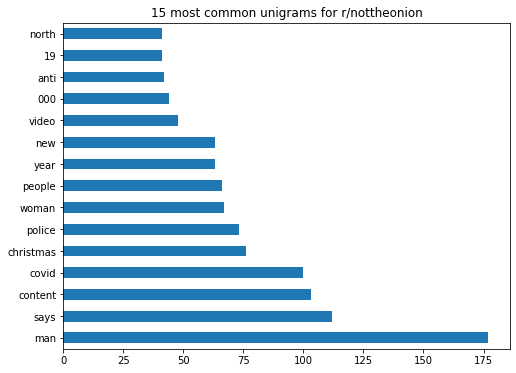

In [35]:
# plotting bargraph for 15 most common unigrams
plt.figure(figsize=(8,6))
notonion_df.sum().sort_values(ascending=False).head(15).plot(kind='barh')
plt.title("15 most common unigrams for r/nottheonion");

In [36]:
# printing counts of 15 most common unigrams
notonion_df.sum().sort_values(ascending=False).head(15)

man          177
says         112
content      103
covid        100
christmas     76
police        73
woman         67
people        66
year          63
new           63
video         48
000           44
anti          42
19            41
north         41
dtype: int64

Quite a number of posts from r/notheonion mention "man", "woman", "police" which could mean that the posts could be about a man or woman doing something weird and the police could be involved as a result. "covid" is also present here which is unsurprising since covid is still a hot topic today

In [37]:
# using CountVectorizer to generate bigrams for analysis
cvec_notonion_bigram = CountVectorizer(ngram_range=(2,2),stop_words='english', min_df=3)
cvec_notonion_bigram.fit(subreddit_posts[subreddit_posts['subreddit']=="nottheonion"]['title'])

notonion_cv_bigram = cvec_notonion_bigram.transform(subreddit_posts[subreddit_posts['subreddit']=="nottheonion"]['title'])
notonion_df_bigram = pd.DataFrame(notonion_cv_bigram.todense(),columns=cvec_notonion_bigram.get_feature_names())

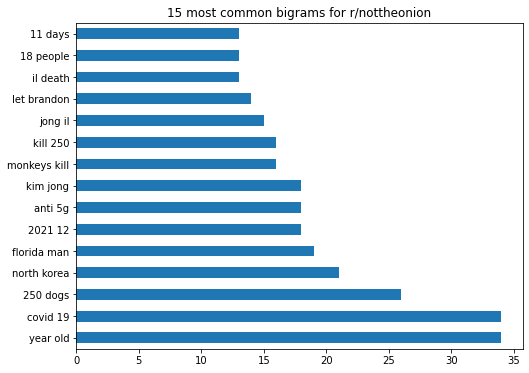

In [38]:
# plotting bargraph for 15 most common bigrams
plt.figure(figsize=(8,6))
notonion_df_bigram.sum().sort_values(ascending=False).head(15).plot(kind='barh')
plt.title("15 most common bigrams for r/nottheonion");

In [39]:
# printing counts of 15 most common bigrams
notonion_df_bigram.sum().sort_values(ascending=False).head(15)

year old        34
covid 19        34
250 dogs        26
north korea     21
florida man     19
2021 12         18
anti 5g         18
kim jong        18
monkeys kill    16
kill 250        16
jong il         15
let brandon     14
il death        13
18 people       13
11 days         13
dtype: int64

The more striking bigrams from 15 most common bigrams are "kim jong", "jong il", "florida man". The posts with "kim jong" and "jong il" are likely about statements/actions by Kim Jong Il or Kim Jong Un which can be quite interesting. Florida man is a popular internet meme as Florida is notorious for strange and unusual happenings so it is unsurprising to see "florida man" in r/nottheonion

There are not too many similarities in the top 15 most common unigrams and bigrams, so the models are likely to be able to differentiate between posts of the 2 subreddits.

Modelling
---

In [40]:
def preprocess_text(text):
    # remove special char and tokens that are digits
    # [^\w\s] to select anything that is not a-z, A-Z, 0-9, _ and whitespace, \d+ to select anything is that made up of digits
    # re.sub to replace them with whitespace and split to remove additional whitespaces
    text = re.sub("[^\w\s]|\d+"," ",text).lower().split()
    
    # remove stopwords
    stopwords_list = stopwords.words("english")
    text_meaningful = [word for word in text if word not in stopwords_list]
    
    # lemmatize words
    lemmatizer = WordNetLemmatizer()
    text_meaningful_lem = [lemmatizer.lemmatize(w) for w in text_meaningful]
    
    # return list of lemmatized words, return None if no text remains to dropna later on
    return (" ".join(text_meaningful_lem)) if len(text_meaningful_lem) > 0 else None

In [41]:
def print_scores(model):
    print(f"Train score: {model.score(X_train,y_train)}")
    print(f"Test score: {model.score(X_test,y_test)}")
    print(f"Cross val score: {cross_val_score(model,X_train,y_train,cv=5).mean()}")

In [42]:
def print_gs_scores(model):
    print(f"Train score: {model.score(X_train,y_train)}")
    print(f"Test score: {model.score(X_test,y_test)}")
    print(f"Cross val score: {model.best_score_}")
    print(f"F1-score: {f1_score(y_test,model.predict(X_test))}")

In [43]:
X = subreddit_posts['title'].apply(preprocess_text)
y = subreddit_posts['subreddit'].map({"nottheonion":0,"TheOnion":1})

In [44]:
# check if preprocessing text has resulted in blanks
X.isna().sum()

0

No null values found after preprocessing text.

In [45]:
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [46]:
# checking distribution of y_train
y_train.value_counts(normalize=True)

0    0.508
1    0.492
Name: subreddit, dtype: float64

In [47]:
# checking distribution of y_test
y_test.value_counts(normalize=True)

1    0.524
0    0.476
Name: subreddit, dtype: float64

Classes are balanced

### Vectorizer Selection

In [48]:
# creating pipelines of CountVectorizer and TfidfVectorizer with Logistic Regression and MultinomialNB
# to see which vectorizer works best
pipe_cvec_logreg = Pipeline([('cvec',CountVectorizer()),('lr',LogisticRegression())])
pipe_tvec_logreg = Pipeline([('tvec',TfidfVectorizer()),('lr',LogisticRegression())])
pipe_cvec_nb = Pipeline([('cvec',CountVectorizer()),('nb',MultinomialNB())])
pipe_tvec_nb = Pipeline([('tvec',TfidfVectorizer()),('nb',MultinomialNB())])

pipe_cvec_logreg.fit(X_train,y_train)
pipe_tvec_logreg.fit(X_train,y_train)
pipe_cvec_nb.fit(X_train,y_train)
pipe_tvec_nb.fit(X_train,y_train)

print("CountVectorizer + Logistic Regression scores:")
print_scores(pipe_cvec_logreg)
print("=====")
print("TfidfVectorizer + Logistic Regression scores:")
print_scores(pipe_tvec_logreg)
print("=====")
print("CountVectorizer + Multinomial Naive Bayes scores:")
print_scores(pipe_cvec_nb)
print("=====")
print("TfidfVectorizer + Multinomial Naive Bayes scores:")
print_scores(pipe_tvec_nb)
print("=====")

CountVectorizer + Logistic Regression scores:
Train score: 0.989
Test score: 0.773
Cross val score: 0.7256666666666666
=====
TfidfVectorizer + Logistic Regression scores:
Train score: 0.954
Test score: 0.779
Cross val score: 0.7226666666666667
=====
CountVectorizer + Multinomial Naive Bayes scores:
Train score: 0.959
Test score: 0.779
Cross val score: 0.7323333333333333
=====
TfidfVectorizer + Multinomial Naive Bayes scores:
Train score: 0.961
Test score: 0.787
Cross val score: 0.7343333333333334
=====


TfidfVectorizer and CountVectorizer yields similar results.  We will proceed with TfidfVectorizer in our subsequent models as it considers the overall document weightage of a word as compared to CountVectorizer which only counts the number of occurrences.

### Model 0: Baseline Model

In [49]:
%%time

# using DummyClassifier as our baseline model
baseline_model = DummyClassifier(random_state=42)
baseline_model.fit(X_train, y_train)
print(f"Baseline model scores:")
print_scores(baseline_model)

Baseline model scores:
Train score: 0.508
Test score: 0.476
Cross val score: 0.508
Wall time: 17.9 ms


### Model 1: Random Forest Classifier

In [50]:
%%time

# Pipeline of TfidfVectorizer and Random Forest
pipe_tvec_rf = Pipeline([('tvec',TfidfVectorizer(strip_accents='unicode')),('rf',RandomForestClassifier(random_state=42))])
pipe_tvec_rf_params = {'tvec__max_features':[None,1000,2000],
                       'tvec__stop_words':[None,'english'],
                       'tvec__ngram_range': [(1,1),(1,2),(1,3)],
                       'rf__n_estimators':[100,200]}

# GridSearch to tune hyperparameters of vectorizer and model
gs_tvec_rf = GridSearchCV(pipe_tvec_rf,pipe_tvec_rf_params,cv=5)
gs_tvec_rf.fit(X_train, y_train);
print("TfidfVectorizer + Random Forest scores:")
print_gs_scores(gs_tvec_rf)

TfidfVectorizer + Random Forest scores:
Train score: 0.9993333333333333
Test score: 0.745
Cross val score: 0.7183333333333333
F1-score: 0.7545717035611165
Wall time: 7min 13s


In [51]:
# best hyperparameter values from the gridsearch
gs_tvec_rf.best_params_

{'rf__n_estimators': 100,
 'tvec__max_features': None,
 'tvec__ngram_range': (1, 1),
 'tvec__stop_words': None}

### Model 2: Logistic Regression 

In [52]:
%%time

# Pipeline of TfidfVectorizer and Logistic Regression
pipe_tvec_lr = Pipeline([('tvec',TfidfVectorizer(strip_accents='unicode')),('lr',LogisticRegression(solver='liblinear'))])
pipe_tvec_lr_params = {'tvec__max_features':[None,1000,2000],
                       'tvec__stop_words':[None,'english'],
                       'tvec__ngram_range': [(1,1),(1,2),(1,3)],
                       'lr__penalty':['l1','l2'],
                       'lr__C':[0.01,0.1,1]}

# GridSearch to tune hyperparameters of vectorizer and model
gs_tvec_lr = GridSearchCV(pipe_tvec_lr,pipe_tvec_lr_params,cv=5)
gs_tvec_lr.fit(X_train, y_train)

print("TfidfVectorizer + Logistic Regression scores")
print_gs_scores(gs_tvec_lr)

TfidfVectorizer + Logistic Regression scores
Train score: 0.996
Test score: 0.776
Cross val score: 0.7323333333333334
F1-score: 0.780392156862745
Wall time: 1min 24s


In [53]:
# best hyperparameter values from the gridsearch
gs_tvec_lr.best_params_

{'lr__C': 1,
 'lr__penalty': 'l2',
 'tvec__max_features': None,
 'tvec__ngram_range': (1, 3),
 'tvec__stop_words': None}

### Model 3: Multinomial Naive Bayes

In [54]:
%%time

# Pipeline of TfidfVectorizer and MultinomialNB
pipe_tvec_nb = Pipeline([('tvec',TfidfVectorizer(strip_accents='unicode')),('nb',MultinomialNB())])
pipe_tvec_nb_params = {'tvec__max_features':[None,1000,2000],
                       'tvec__stop_words':[None,'english'],
                       'tvec__ngram_range': [(1,1),(1,2),(1,3)],
                       'nb__alpha':[1,10,100]}

# GridSearch to tune hyperparameters of vectorizer and model
gs_tvec_nb = GridSearchCV(pipe_tvec_nb,pipe_tvec_nb_params,cv=5)
gs_tvec_nb.fit(X_train, y_train)

print("TfidfVectorizer + Multinomial Naive Bayes scores:")
print_gs_scores(gs_tvec_nb)

TfidfVectorizer + Multinomial Naive Bayes scores:
Train score: 0.9953333333333333
Test score: 0.779
Cross val score: 0.74
F1-score: 0.7765419615773508
Wall time: 38.1 s


In [55]:
# best hyperparameter values from the gridsearch
gs_tvec_nb.best_params_

{'nb__alpha': 1,
 'tvec__max_features': None,
 'tvec__ngram_range': (1, 2),
 'tvec__stop_words': None}

### Model 4: Support Vector Classifier

In [56]:
%%time

# Pipeline of TfidfVectorizer and Support Vector Classifier
pipe_tvec_svc = Pipeline([('tvec',TfidfVectorizer(strip_accents='unicode')),('svc',SVC(random_state=42))])
pipe_tvec_svc_params = {'tvec__max_features':[None,1000,2000],
                        'tvec__stop_words':[None,'english'],
                        'tvec__ngram_range': [(1,1),(1,2),(1,3)],
                        'svc__C':[1,0.1],
                        'svc__degree':[2,3]}

# GridSearch to tune hyperparameters of vectorizer and model
gs_tvec_svc = GridSearchCV(pipe_tvec_svc,pipe_tvec_svc_params,cv=5)
gs_tvec_svc.fit(X_train, y_train)

print("TfidfVectorizer + Support Vector Classifier scores:")
print_gs_scores(gs_tvec_svc)

TfidfVectorizer + Support Vector Classifier scores:
Train score: 0.9993333333333333
Test score: 0.786
Cross val score: 0.7419999999999999
F1-score: 0.7965779467680609
Wall time: 5min 3s


In [57]:
# best hyperparameter values from the gridsearch
gs_tvec_svc.best_params_

{'svc__C': 1,
 'svc__degree': 2,
 'tvec__max_features': None,
 'tvec__ngram_range': (1, 2),
 'tvec__stop_words': None}

Evaluation
---

|                                   | Train accuracy | Test accuracy | Cross val score | F1 score |
|-----------------------------------|----------------|---------------|-----------------|----------|
| Baseline model (Dummy Classifier) | 0.508          | 0.476         | 0.508           | -        |
| Random Forest Classifier          | 0.999          | 0.745         | 0.718           | 0.754    |
| Logistic Regression               | 0.996          | 0.776         | 0.732           | 0.780    |
| Multinomial Naive Bayes           | 0.995          | 0.779         | 0.740           | 0.777    |
| Support Vector Classifier         | 0.999          | 0.786         | 0.742           | 0.797    |

We will evaluate the models using the accuracy score and F1 score. The accuracy score is meaningful in this problem as our training data has balanced classes, and we chose F1 score as neither false positive nor false negative is more important than the other.

The baseline model is able to predict with 47.6% accuracy and is the same as if we predicted every post in the test set to be from r/TheOnion.

From the accuracy scores, all 4 models are overfit with a train accuracy score of > 99% but they achieve decent test accuracy scores of 74% and above, with the Support Vector Classifier performing the best with a test accuracy score of 78.6%. Likewise, Support Vector Classifier has the best F1 score of 79.7%.

Based on accuracy scores, the Support Vector Classifier is the best performing model.

Text(0.5, 1.0, 'Receiver Operating Characteristic (ROC) Curve')

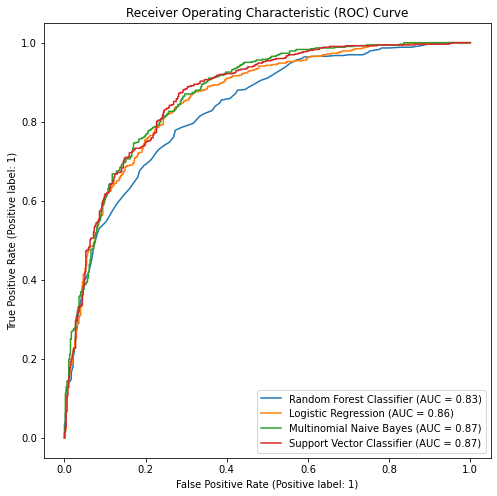

In [58]:
plt.figure(figsize=(8,8))
plot_roc_curve(gs_tvec_rf,X_test,y_test, ax = plt.gca(), name = "Random Forest Classifier")
plot_roc_curve(gs_tvec_lr,X_test,y_test, ax = plt.gca(), name = "Logistic Regression")
plot_roc_curve(gs_tvec_nb,X_test,y_test, ax = plt.gca(), name = "Multinomial Naive Bayes")
plot_roc_curve(gs_tvec_svc,X_test,y_test, ax = plt.gca(), name = "Support Vector Classifier")
plt.title("Receiver Operating Characteristic (ROC) Curve")

From the ROC curves, it is clear that the Random Forest Classifier is the worst performing model of the 4. The other 3 models have similar ROC AUC of 0.86/0.87, so they are performing similarly. However, the ROC curve for the Logistic Regression is mostly below the ROC curves for Multinomial Naive Bayes and Support Vector Classifier. 

Based on the ROC curves and ROC AUC values, we should select either the Multinomial Naive Bayes or the Support Vector Classifier models.

In [59]:
rf_pred = gs_tvec_rf.predict(X_test)
lr_pred = gs_tvec_lr.predict(X_test)
nb_pred = gs_tvec_nb.predict(X_test)
svc_pred = gs_tvec_svc.predict(X_test)

cm_rf = confusion_matrix(y_test,rf_pred)
cm_lr = confusion_matrix(y_test,lr_pred)
cm_nb = confusion_matrix(y_test,nb_pred)
cm_svc = confusion_matrix(y_test,svc_pred)

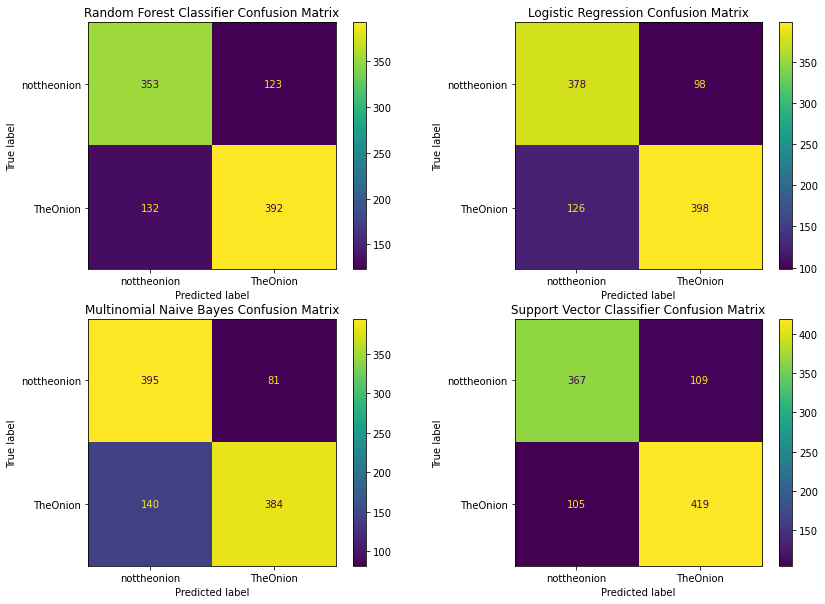

In [60]:
plt.figure(figsize=(14,10))

cm_disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=['nottheonion', 'TheOnion'])
cm_disp_rf.plot(ax=plt.subplot(2,2,1))
plt.title("Random Forest Classifier Confusion Matrix")

cm_disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=['nottheonion', 'TheOnion'])
cm_disp_lr.plot(ax=plt.subplot(2,2,2))
plt.title("Logistic Regression Confusion Matrix")

cm_disp_nb = ConfusionMatrixDisplay(confusion_matrix=cm_nb, display_labels=['nottheonion', 'TheOnion'])
cm_disp_nb.plot(ax=plt.subplot(2,2,3))
plt.title("Multinomial Naive Bayes Confusion Matrix")

cm_disp_svc = ConfusionMatrixDisplay(confusion_matrix=cm_svc, display_labels=['nottheonion', 'TheOnion'])
cm_disp_svc.plot(ax=plt.subplot(2,2,4))
plt.title("Support Vector Classifier Confusion Matrix");

From the confusion matrices, it shows that Support Vector Classifier has the most balanced false postives and false negatives, while the other 3 models had more false negatives. On the other hand, Logistic Regression and Multinomial Naive Bayes had less false negatives. If the goal was to minimise false negatives, i.e. minimise falsely classifying a post from r/nottheonion as a post from r/TheOnion, Logistic Regression or Multinomial Naive Bayes might be a better choice, but since neither false positive nor false negative is more important than the other, Support Vector Classifier might be the better choice, based on the confusion matrix.

|                           | False Positive | False Negative | Ratio |
|---------------------------|----------------|----------------|-------|
| Random Forest Classifier  | 129            | 115            | 1.12  |
| Logistic Regression       | 98             | 126            | 0.78  |
| Multinomial Naive Bayes   | 81             | 140            | 0.58  |
| Support Vector Classifier | 109            | 105            | 1.04  |

Looking at the ratio of false positives to false negatives, as we want a balanced ratio, the ideal model would have a ratio of 1. The Support Vector Classifier has a ratio that is closest to 1, which coincides with our earlier evaluations & observations.

From the above, we can conclude that the best model here is the Support Vector Classifier. It has the highest accuracy and F1 score, highest ROC curve & highest ROC AUC value, as well as having balanced false positives and false negatives.

A few reasons why the Support Vector Classifier is performing better than the other 3 models could be that the boundaries between the 2 classes are non-linear, and Support Vector Machines are highly effective in high-dimension data, which is common for NLP data.

Unfortunately, as Support Vector Machines are a blackbox model, we will not be able to further interpret the models results and gain insight as to what features are most likely to lead to the post being classified as belonging to r/TheOnion or not. However, since we are more interested in the predicting power, it is an acceptable drawback.

Conclusion and Recommendations
---

We were tasked to build classification model that could classify whether a post belonged to r/TheOnion or r/nottheonion based solely on the post titles, given that only the post titles were recovered from the deleted data. The best performing model was a Support Vector Classifier model which had features created using the TfidfVectorizer. TfidfVectorizer is preferred over CountVectorizer as it got better results when loading the vectorized data into the models, and also it gives the different words a different weight based on how often it appears whereas CountVectorizer simply counts the number of occurrences which may not be as useful.  The model was able to predict with an accuracy of 78.6% and has a F1-score of 79.7%.

Hence, with an accuracy score of almost 80%, we are confident of correctly classifying 7-8 out of every 10 deleted posts. We therefore recommend using the Support Vector Classifier with TfidfVectorizer to classify the recovered deleted posts. For the posts that were wrongly classified, we would have to rely on user reports and/or manual verification by the moderators of the respective subreddits. The results also show that classification models would be feasible to be used in the development of automated moderators.

To improve the model, more data can be gathered to train the model since machine learning models can always benefit from more data. Another thing we could do is to examine the text more closely, to remove more words as stopwords. We could also look into engineering more features using the metadata of reddit posts, like word count, character count, sentiment analysis etc.